# 10wk-1: 순환신경망 (2)

최규빈  
2022-11-03

> 순환신경망 intro (2)– abc예제, abdc예제, AbAcAd예제(1)

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-wXdABtimM1pYK5TjPTBA6X>

# import

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Define some funtions

In [33]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

# Exam2: abc

## data

In [34]:
txt = list('abc')*100
txt[:10]

In [35]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [36]:
txt_x[:5],txt_y[:5]

## 하나의 은닉노드를 이용한 풀이 – 억지로 성공

`-` 데이터정리

In [15]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

`-` 학습

In [37]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=1),
    torch.nn.Tanh(),
    #===#
    torch.nn.Linear(in_features=1,out_features=3)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [38]:
for epoc in range(5000):
    ## 1
    ## 2 
    loss = loss_fn(net(x),y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과해석

In [53]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

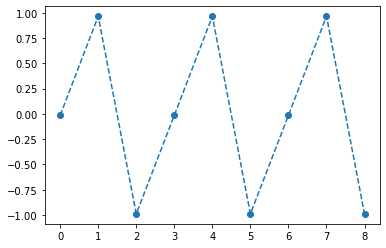

In [54]:
plt.plot(hidden[:9],'--o')

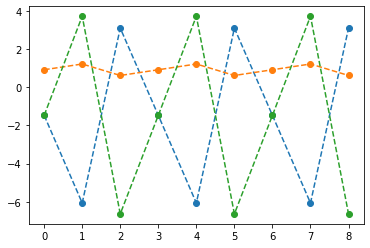

In [56]:
plt.plot(net(x).data[:9],'--o')

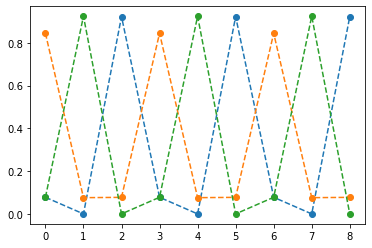

In [60]:
plt.plot(yhat[:9],'--o')

-   억지로 맞추고있긴한데 파라메터가 부족해보인다.

`-` 결과시각화1

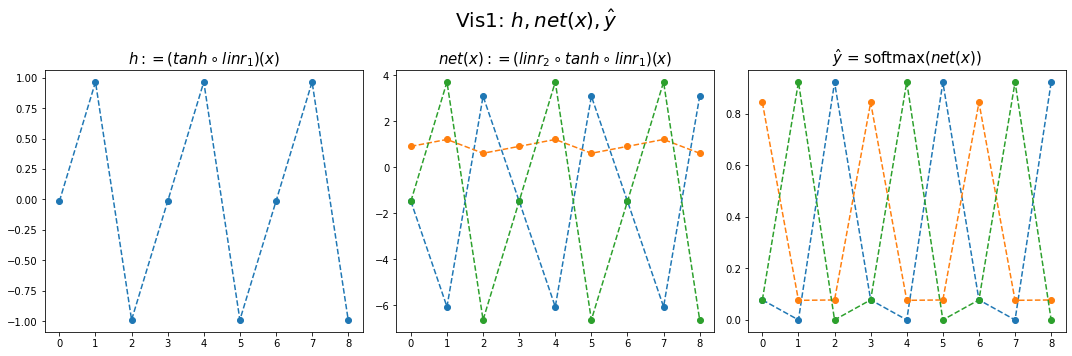

In [63]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

In [14]:
hidden[:9], (net[-1].weight.data).T, net[-1].bias.data

In [64]:
hidden[:9]@(net[-1].weight.data).T + net[-1].bias.data

-   (파랑,주황,초록) 순서로 그려짐
-   파랑 = hidden \* (-4.6804) + (-1.5440)
-   주황 = hidden \* (0.3071) + (0.9143)
-   초록 = hidden \* (5.2894) + (-1.3970)

`-` 내부동작을 잘 뜯어보니까 사실 엉성해. 엄청 위태위태하게 맞추고
있었음.

-   weight: 파랑과 초록을 구분하는 역할을 함
-   weight + bias: 뭔가 교모하게 애매한 주황값을 만들어서 애매하게
    ’b’라고 나올 확률을 학습시킨다. $\to$ 사실 학습하는 것 같지 않고
    때려 맞추는 느낌, 쓸수있는 weight가 한정적이라서 생기는 현상
    (양수,음수,0)

------------------------------------------------------------------------

**[참고](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html):
torch.nn.Linear()의 비밀?**

-   사실 ${\boldsymbol y}={\boldsymbol x}{\bf W} + {\boldsymbol b}$
    꼴에서의 ${\bf W}$와 ${\boldsymbol b}$가 저장되는게 아니다.
-   ${\boldsymbol y}={\boldsymbol x}{\bf A}^T + {\boldsymbol b}$
    꼴에서의 ${\bf A}$와 ${\boldsymbol b}$가 저장된다.
-   ${\bf W} = {\bf A}^T$ 인 관계에 있으므로 l1.weight 가 우리가
    생각하는 ${\bf W}$ 로 해석하려면 사실 transpose를 취해줘야 한다.

**왜 이렇게..?**

-   계산의 효율성 때문 (numpy의 구조를 알아야함)
-   ${\boldsymbol x}$, ${\boldsymbol y}$ 는 수학적으로는 col-vec 이지만
    메모리에 저장할시에는 row-vec 로 해석하는 것이 자연스럽다. (사실
    메모리는 격자모양으로 되어있지 않음)

***잠깐 딴소리!!***

(예시1)

In [65]:
_arr = np.array(range(4)).reshape(2,2)

In [17]:
_arr.strides

-   아래로 한칸 = 16칸 jump
-   오른쪽으로 한칸 = 8칸 jump

(예시2)

In [67]:
_arr = np.array(range(6)).reshape(3,2)

In [69]:
_arr.strides

-   아래로 한칸 = 16칸 jump
-   오른쪽으로 한칸 = 8칸 jump

(예시3)

In [70]:
_arr = np.array(range(6)).reshape(2,3)

In [21]:
_arr.strides

-   아래로 한칸 = 24칸 jump
-   오른쪽으로 한칸 = 8칸 jump

(예시4)

In [72]:
_arr = np.array(range(4),dtype=np.int8).reshape(2,2)

In [73]:
_arr

In [74]:
_arr.strides

-   아래로한칸 = 2칸 (= 2바이트 jump = 16비트 jump)
-   오른쪽으로 한칸 = 1칸 jump (= 1바이트 jump = 8비트 jump)

**진짜 참고..**

-   1바이트 = 8비트
-   1바이트는 2^8=256 의 정보 표현
-   np.int8은 8비트로 정수를 저장한다는 의미

In [75]:
2**8

In [25]:
print(np.array(55,dtype=np.int8))
print(np.array(127,dtype=np.int8))
print(np.array(300,dtype=np.int8)) # overflow 

55
127
44

***딴소리 끝!!***

------------------------------------------------------------------------

`-` 결과시각화2

In [26]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

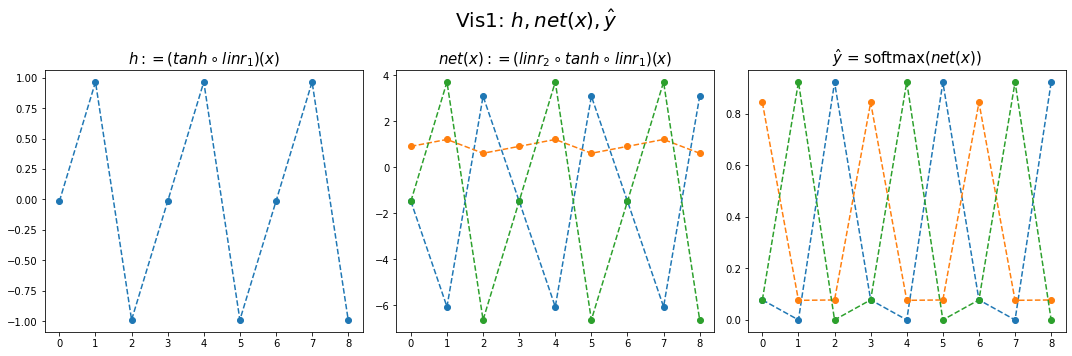

In [63]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

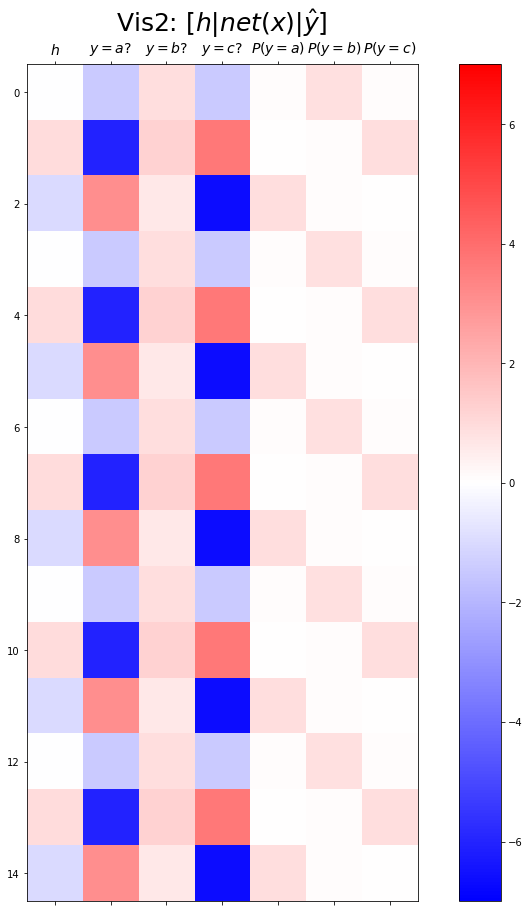

In [27]:
plt.matshow(combined[:15],vmin=-7,vmax=7,cmap='bwr')
plt.xticks(range(7), labels=[r'$h$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

# Exam3: abcd

## data

In [76]:
txt = list('abcd')*100
txt[:10]

In [77]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [78]:
txt_x[:5],txt_y[:5]

## 하나의 은닉노드를 이용한 풀이 – 억지로 성공

`-` 데이터정리

In [95]:
mapping = {'a':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

`-` 학습

In [105]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [106]:
net[0].weight.data = torch.tensor([[-0.3333],[-2.5000],[5.0000],[0.3333]])

net[-1].weight.data = torch.tensor([[1.5000],[-6.0000],[-2.0000],[6.0000]])
net[-1].bias.data = torch.tensor([0.1500, -2.0000,  0.1500, -2.000])

In [107]:
for epoc in range(5000):
    ## 1
    ## 2 
    loss = loss_fn(net(x),y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [108]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

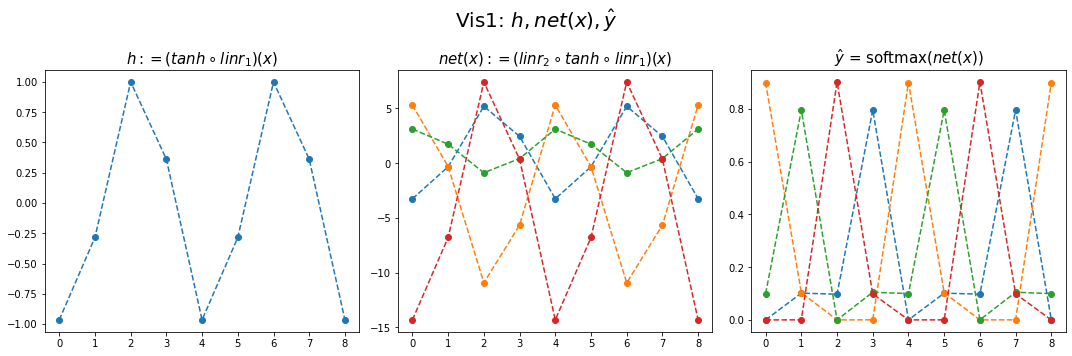

In [109]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [110]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

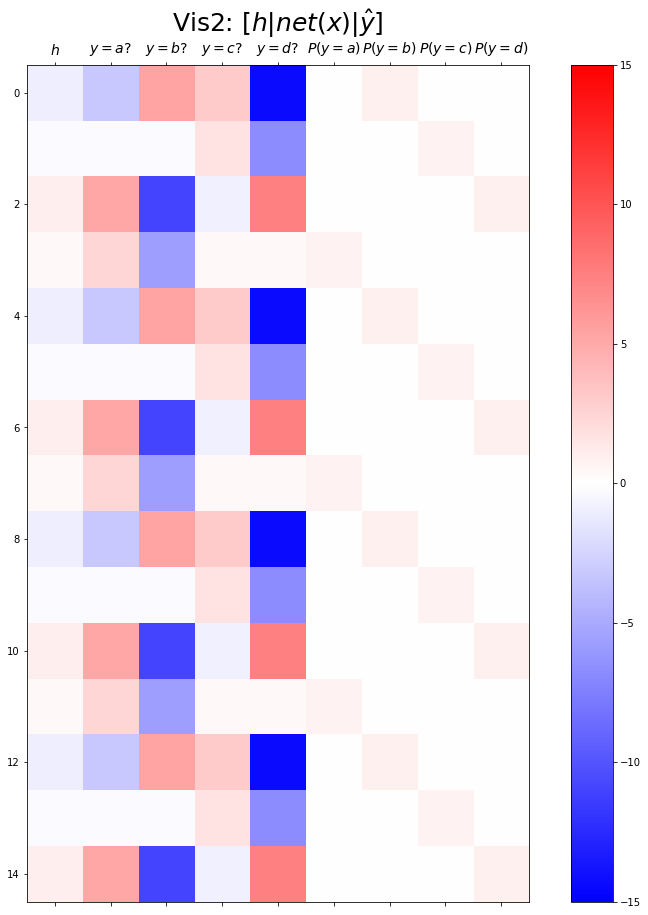

In [111]:
plt.matshow(combined[:15],vmin=-15,vmax=15,cmap='bwr')
plt.xticks(range(9), labels=[r'$h$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

## 두개의 은닉노드를 이용한 풀이 – 깔끔한 성공

`-` 데이터정리

In [113]:
mapping = {'a':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

`-` 학습

In [114]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [115]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [116]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

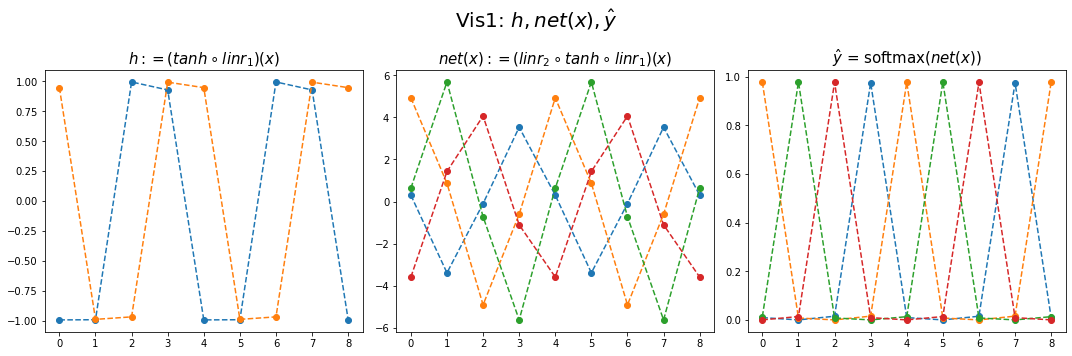

In [117]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [47]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

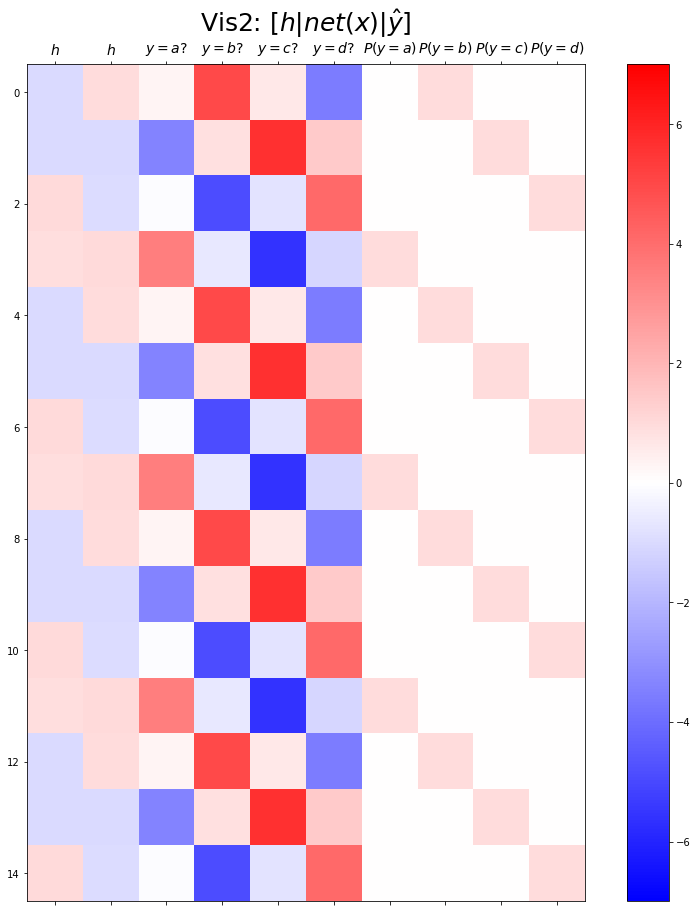

In [48]:
plt.matshow(combined[:15],vmin=-7,vmax=7,cmap='bwr')
plt.xticks(range(10), labels=[r'$h$',r'$h$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

# Exam4: AbAcAd

## data

In [125]:
txt = list('AbAcAd')*100
txt[:10]

In [126]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [127]:
txt_x[:5],txt_y[:5]

## 두개의 은닉노드를 이용한 풀이 – 실패

`-` 데이터정리

In [128]:
mapping = {'A':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

`-` 학습

In [129]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [130]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [131]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

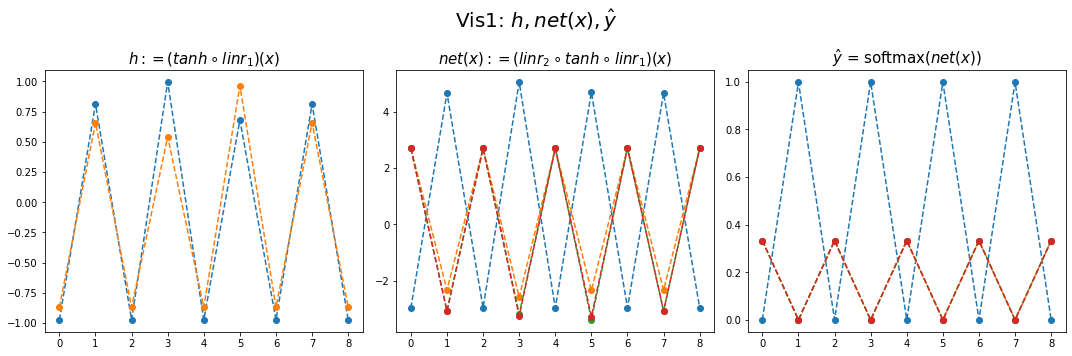

In [132]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [133]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

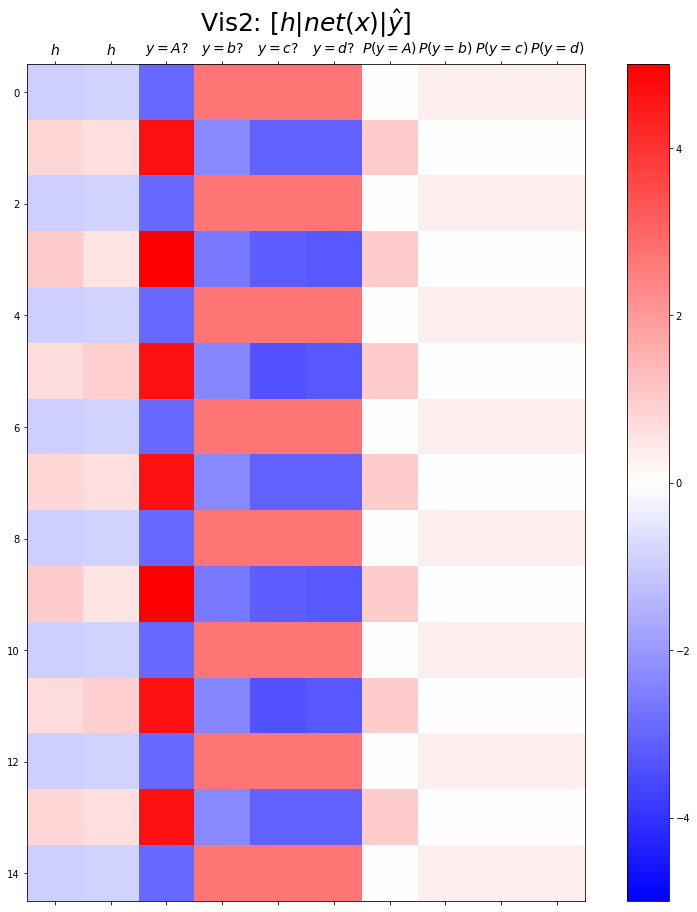

In [134]:
plt.matshow(combined[:15],vmin=-5,vmax=5,cmap='bwr')
plt.xticks(range(10), labels=[r'$h$',r'$h$',r'$y=A?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=A)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

-   실패

`-` 실패를 해결하는 순진한 접근방식: 위 문제를 해결하기 위해서는 아래와
같은 구조로 데이터를 다시 정리하면 될 것이다.

|  X  |  y  |
|:---:|:---:|
| A,b |  A  |
| b,A |  c  |
| A,c |  A  |
| c,A |  d  |
| A,d |  A  |
| d,A |  b  |
| A,b |  A  |
| b,A |  c  |
|  …  |  …  |

`-` 순진한 접근방식의 비판: - 결국 정확하게 직전 2개의 문자를 보고 다음
문제를 예측하는 구조 - 만약에 직전 3개의 문자를 봐야하는 상황이 된다면
또 다시 코드를 수정해야함. - 그리고 실전에서는 직전 몇개의 문자를
봐야하는지 모름.

***이것에 대한 해결책은 순환신경망이다. 다음시간에 설명***

# 숙제

주어진 자료가 다음과 같다고 하자.

In [4]:
txt = list('abcde')*100
txt[:10]

In [5]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [6]:
txt_x[:5],txt_y[:5]

아래 코드를 변형하여 적절한 네트워크를 설계하고 위의 자료를 학습하라.
(깔끔한 성공을 위한 최소한의 은닉노드를 설정할 것)

``` python
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=??,embedding_dim=??),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=??,out_features=??)
)
```

(풀이)

a,b,c,d,e 를 표현함에 있어서 3개의 은닉노드면 충분하다.

-   1개의 은닉노드 -\> 2개의 문자를 표현할 수 있음.
-   2개의 은닉노드 -\> 4개의 문자를 표현할 수 있음.
-   3개의 은닉노드 -\> 8개의 문자를 표현할 수 있음.

In [11]:
mapping = {'a':0,'b':1,'c':2,'d':3,'e':4}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))
x[:5],y[:5]

In [14]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=5,embedding_dim=3),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=3,out_features=5)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [15]:
for epoc in range(5000):
    ## 1
    yhat = net(x)
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [16]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

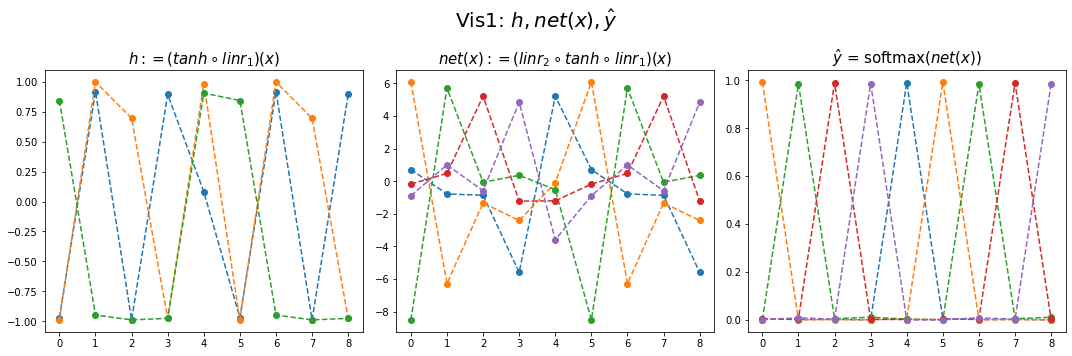

In [19]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [20]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

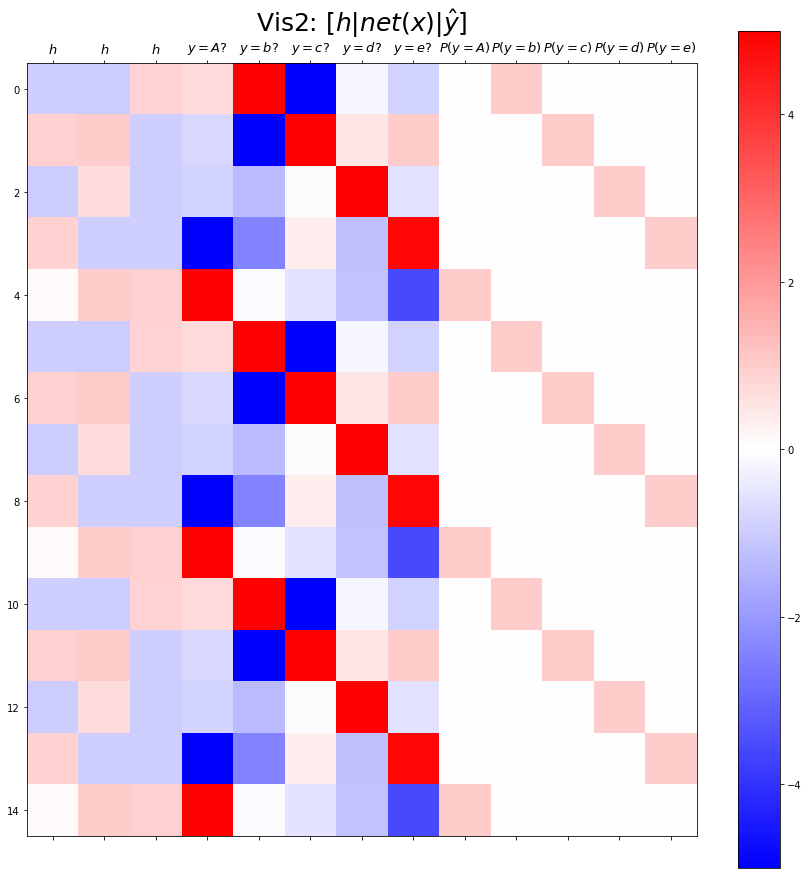

In [31]:
plt.matshow(combined[:15],vmin=-5,vmax=5,cmap='bwr')
plt.xticks(range(13), labels=[r'$h$',r'$h$',r'$h$',
                              r'$y=A?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$y=e?$',
                              r'$P(y=A)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$',r'$P(y=e)$'],size=13)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)